In [1]:
%pip install scikit-learn
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import numpy as np, pandas as pd, os, glob
from torchsummary import summary
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cluster
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Defaulting to user installation because normal site-packages is not writeable
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 6.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Total 6049 (delta 0), reused 0 (delta 0), pack-reused 6049 (from 1)
Receiving objects: 100% (6049/6049), 329.52 MiB | 1.76 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Updating files: 100% (5805/5805), done.


In [3]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2
from copy import deepcopy

In [4]:
class FacesData(Dataset):
    def __init__(self, df):
        super(FacesData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                              std = [0.229, 0.224, 0.225])
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, ix):
        img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix, 0]
        img = cv2.imread(img_path) / 255
        kp = deepcopy(self.df.iloc[ix, 1:].tolist())
        kp_x = (np.array(kp[0::2]) / img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2]) / img.shape[0]).tolist()
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2)
        img = self.preprocess_input(img)
        return img, kp2
    
    def preprocess_input(self, img):
        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img).permute(2, 0, 1)
        img = self.normalize(img).float()
        return img.to(device)
    
    def load_img(self, ix):
        img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix, 0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255
        img = cv2.resize(img, (224, 224))
        return img



In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.2, random_state = 101)
train_dataset = FacesData(train.reset_index(drop = True))
test_dataset = FacesData(test.reset_index(drop = True))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [6]:
def get_model():
    model = models.vgg16(pretrained = True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(nn.Conv2d(512, 512, 3),
                                  nn.MaxPool2d(2),
                                  nn.Flatten())
    model.classifier = nn.Sequential(nn.Linear(2048, 512),
                                     nn.ReLU(),
                                     nn.Dropout(0.5),
                                     nn.Linear(512, 136),
                                     nn.Sigmoid())
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
    return model.to(device), criterion, optimizer

In [7]:
model, criterion, optimizer = get_model()

/home/saik/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/saik/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def train_batch(img, kps, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss

In [9]:
@torch.no_grad()
def validate_batch(img, kps, model, criterion):
    model.eval()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    return _kps, loss

In [10]:
train_loss, test_loss = [], []
n_epochs = 50

for epoch in range(n_epochs):
    print(f"epochs {epoch + 1} / 50")
    epoch_train_loss, epoch_test_loss = 0, 0

    for ix, (img, kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (ix + 1)

    for ix, (img, kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (ix + 1)

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

epochs 1 / 50
epochs 2 / 50
epochs 3 / 50
epochs 4 / 50
epochs 5 / 50
epochs 6 / 50
epochs 7 / 50
epochs 8 / 50
epochs 9 / 50
epochs 10 / 50
epochs 11 / 50
epochs 12 / 50
epochs 13 / 50
epochs 14 / 50
epochs 15 / 50
epochs 16 / 50
epochs 17 / 50
epochs 18 / 50
epochs 19 / 50
epochs 20 / 50
epochs 21 / 50
epochs 22 / 50
epochs 23 / 50
epochs 24 / 50
epochs 25 / 50
epochs 26 / 50
epochs 27 / 50
epochs 28 / 50
epochs 29 / 50
epochs 30 / 50
epochs 31 / 50
epochs 32 / 50
epochs 33 / 50
epochs 34 / 50
epochs 35 / 50
epochs 36 / 50
epochs 37 / 50
epochs 38 / 50
epochs 39 / 50
epochs 40 / 50
epochs 41 / 50
epochs 42 / 50
epochs 43 / 50
epochs 44 / 50
epochs 45 / 50
epochs 46 / 50
epochs 47 / 50
epochs 48 / 50
epochs 49 / 50
epochs 50 / 50


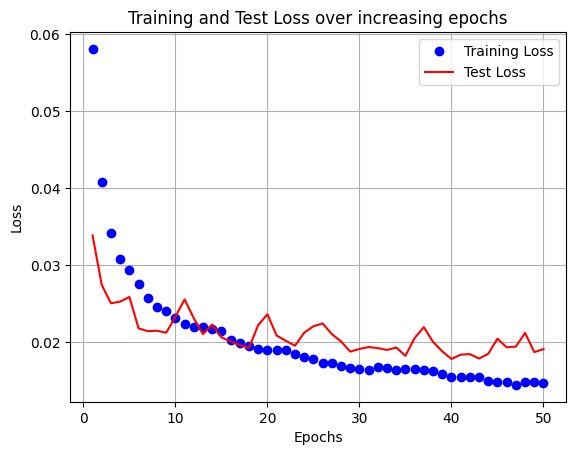

In [11]:
epochs = np.arange(50) + 1
import matplotlib.ticker as mticker

plt.plot(epochs, train_loss, 'bo', label = 'Training Loss')
plt.plot(epochs, test_loss, 'r', label = 'Test Loss')
plt.title('Training and Test Loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

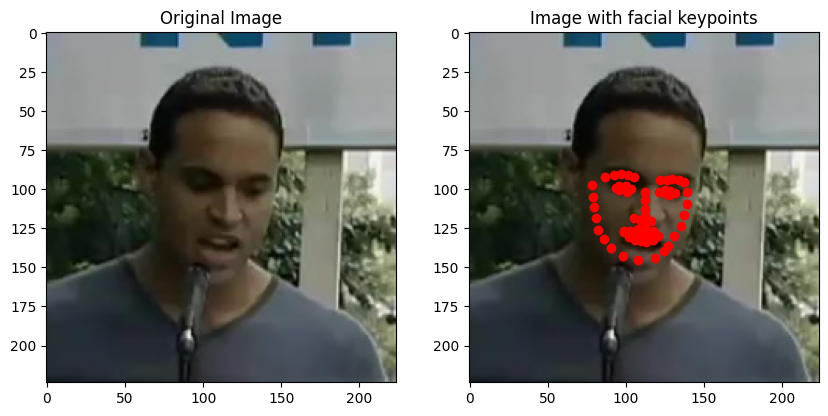

In [16]:
ix = 51
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title('Original Image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68] * 224, kp[68:]*224, c = 'r')
plt.grid(False)
plt.show()